In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from dataset import Dummy, QM7, QM7b, QM7X, QM9, ANI1x
from learning import Learn, Selector

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

<class 'cosmosis.dataset.Dummy'> dataset created...
epoch: 0 of 10, train loss: 4973.30256702054, val loss: 850.8762613932291, lr: 0.01
epoch: 1 of 10, train loss: 680.6096092962449, val loss: 789.3142395019531, lr: 0.01
epoch: 2 of 10, train loss: 582.2311371834047, val loss: 571.3934631347656, lr: 0.01
epoch: 3 of 10, train loss: 580.1006243305821, val loss: 576.5746358235677, lr: 0.01
epoch: 4 of 10, train loss: 463.8358843403478, val loss: 696.0574544270834, lr: 0.01
epoch: 5 of 10, train loss: 489.81193197927166, val loss: 523.71533203125, lr: 0.01
epoch: 6 of 10, train loss: 431.34542895901586, val loss: 523.9587809244791, lr: 0.01
epoch: 7 of 10, train loss: 445.7092472199471, val loss: 602.2615661621094, lr: 0.01
epoch: 8 of 10, train loss: 448.9596705282888, val loss: 386.69923909505206, lr: 0.01
epoch: 9 of 10, train loss: 466.79100479618194, val loss: 533.9372762044271, lr: 0.01
test loss: 362.88043212890625
y_pred:
tensor([[ -70.6730],
        [  60.1609],
        [ 110.418

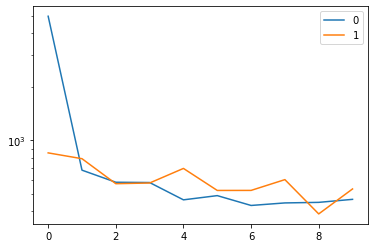

learning time: 0:00:06.695184


In [4]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}
ds_params = {'make': 'make_regression',
             'make_params': {'n_samples': 10000,
                             'n_features': 128}}

opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 10}
l = Learn(Dummy, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=10)

<class 'dataset.QM7'> dataset created...
epoch: 0 of 10, train loss: 902.9903807206588, val loss: 128.99822616577148, lr: 0.01
epoch: 1 of 10, train loss: 141.402456110174, val loss: 92.11944961547852, lr: 0.01
epoch: 2 of 10, train loss: 161.33454721624202, val loss: 125.23654556274414, lr: 0.01
epoch: 3 of 10, train loss: 128.29510844837534, val loss: 164.42262268066406, lr: 0.01
epoch: 4 of 10, train loss: 114.59977583451705, val loss: 89.4122428894043, lr: 0.01
epoch: 5 of 10, train loss: 119.39933984929866, val loss: 216.96659088134766, lr: 0.01
epoch: 6 of 10, train loss: 102.87362220070578, val loss: 98.5996208190918, lr: 0.01
epoch: 7 of 10, train loss: 98.37757596102628, val loss: 125.6842269897461, lr: 0.01
epoch: 8 of 10, train loss: 117.49724058671431, val loss: 82.1800308227539, lr: 0.01
epoch: 9 of 10, train loss: 84.1972449909557, val loss: 64.7420825958252, lr: 0.01
test loss: 63.40692710876465
y_pred:
tensor([[-1654.8684],
        [-1573.0499],
        [-2089.8049],
  

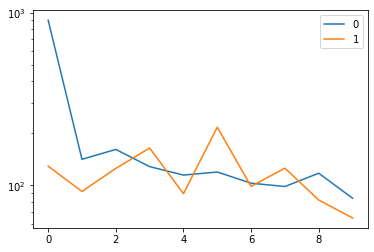

learning time: 0:00:07.628647


In [5]:
model_params = {'D_in': 23*23, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}
ds_params = {}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 10,
                'cooldown': 10}
opt_params = {'lr': 0.01}

l = Learn(QM7, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=10)

<class 'dataset.QM7b'> dataset created...
epoch: 0 of 10, train loss: 974.9116606278853, val loss: 171.5843734741211, lr: 0.01
epoch: 1 of 10, train loss: 179.3591204556552, val loss: 128.85911560058594, lr: 0.01
epoch: 2 of 10, train loss: 147.40245645696467, val loss: 134.98947525024414, lr: 0.01
epoch: 3 of 10, train loss: 123.99550524624911, val loss: 132.47130584716797, lr: 0.01
epoch: 4 of 10, train loss: 106.89513917402788, val loss: 83.88762283325195, lr: 0.01
epoch: 5 of 10, train loss: 129.7305169539018, val loss: 86.97790145874023, lr: 0.01
epoch: 6 of 10, train loss: 86.38439525257458, val loss: 77.63436889648438, lr: 0.01
epoch: 7 of 10, train loss: 87.65862794355913, val loss: 103.24352645874023, lr: 0.01
epoch: 8 of 10, train loss: 81.25455093383789, val loss: 97.09136962890625, lr: 0.01
epoch: 9 of 10, train loss: 82.092397516424, val loss: 97.31331634521484, lr: 0.01
test loss: 107.64485931396484
y_pred:
tensor([[-1923.5044],
        [-1317.6005],
        [-1286.8313],

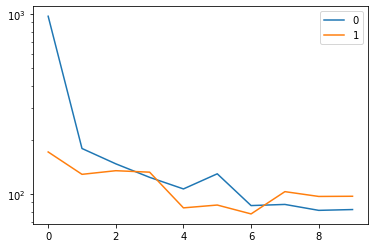

learning time: 0:00:12.655603


In [6]:
model_params = {'D_in': 23*23+13, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}
ds_params = {'target': 'E', 
             'features': ['alpha_p','alpha_s','HOMO_g','HOMO_p','HOMO_z','LUMO_g',
                          'LUMO_p','LUMO_z','IP','EA','E1','Emax','Imax']}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 10,
                'cooldown': 10}
opt_params = {'lr': 0.01}

l = Learn(QM7b, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=10)

loading QM9 datadic from a pickled copy...
<class 'dataset.QM9'> dataset created...
epoch: 0 of 10, train loss: 105.70489700317383, val loss: 39.10813061396281, lr: 0.01
epoch: 1 of 10, train loss: 36.33780523300171, val loss: 32.779309590657554, lr: 0.01
epoch: 2 of 10, train loss: 36.65473048210144, val loss: 28.320070425669353, lr: 0.01
epoch: 3 of 10, train loss: 29.515560789108278, val loss: 24.657922585805256, lr: 0.01
epoch: 4 of 10, train loss: 26.756547346115113, val loss: 24.439661026000977, lr: 0.01
epoch: 5 of 10, train loss: 25.559850673675538, val loss: 21.417516946792603, lr: 0.01
epoch: 6 of 10, train loss: 22.4435249710083, val loss: 22.963116963704426, lr: 0.01
epoch: 7 of 10, train loss: 22.30394359588623, val loss: 19.707998752593994, lr: 0.01
epoch: 8 of 10, train loss: 22.778602380752563, val loss: 17.18314552307129, lr: 0.01
epoch: 9 of 10, train loss: 21.57356593132019, val loss: 17.77360685666402, lr: 0.01
test loss: 18.835384607315063
y_pred:
tensor([[-346.796

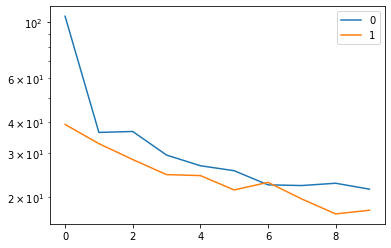

learning time: 0:00:11.179532


In [3]:
model_params = {'D_in': 12*12, # nxn coulomb matrix
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}
ds_params = {'n': 133885, 
             'features': ['coulomb'], 
             'target': 'U0',
             'pad': 12, 
             'filter_on': ('n_atoms','>','12'),
             'use_pickle': 'n_atoms_less_than_12.p'}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 10,
                'cooldown': 10}
opt_params = {'lr': 0.01}

l = Learn(QM9, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=32, epochs=10)

structures loaded:  9342
<class 'dataset.ANI1x'> dataset created...
epoch: 0 of 10, train loss: 288.2543767667712, val loss: 90.71536193376033, lr: 0.01
epoch: 1 of 10, train loss: 76.77653279482607, val loss: 62.282363523878814, lr: 0.01
epoch: 2 of 10, train loss: 70.68200535311162, val loss: 61.553927547363045, lr: 0.01
epoch: 3 of 10, train loss: 75.18646982207021, val loss: 57.3473816672755, lr: 0.01
epoch: 4 of 10, train loss: 61.082487815667335, val loss: 76.7485863983542, lr: 0.01
epoch: 5 of 10, train loss: 56.81468696741221, val loss: 70.8352185490401, lr: 0.01
epoch: 6 of 10, train loss: 53.302466726828825, val loss: 72.55390398589557, lr: 0.01
epoch: 7 of 10, train loss: 70.26793424945369, val loss: 56.38951246289791, lr: 0.01
epoch: 8 of 10, train loss: 66.38729469272029, val loss: 49.94145043943198, lr: 0.01
epoch: 9 of 10, train loss: 51.717379757848846, val loss: 68.23519835515881, lr: 0.01
test loss: 79.90015571248287
y_pred:
tensor([[-734.0829],
        [-471.4678],
 

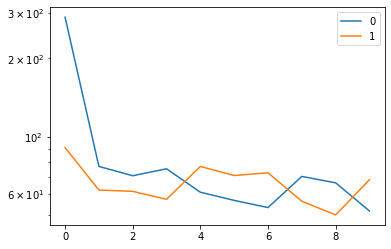

learning time: 0:00:19.685472


In [8]:
model_params = {'D_in': 32*63+63+63+63, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel',
                'padding_idx': 0}

ds_params = {'features': ['atomic_numbers','coordinates'],
             'targets': ['wb97x_dz.energy'],
             'embed': [(6,32,False)],
             'pad': 63, #length of the longest molecule in the dataset
             'criterion': None,
             'conformation': 'random',
             'in_file': './data/ani1x/ani1x-release.h5'}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 10,
                'cooldown': 10}
opt_params = {'lr': 0.01}

l = Learn(ANI1x, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=10)

In [ ]:
ds_params = {'features': ['atNUM','atXYZ'],
             'pad': 23,
             'targets': ['eAT'],
             'embed': [(9,64,True)],
             'selector': ['i1-c1-opt'],
             'use_h5': False}

model_params = {'D_in': 64*23+23+23+23, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'padding_idx': 0}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 20,
                'cooldown': 10}
opt_params = {'lr': 0.01}

l = Learn(QM7X, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=10)

#find the longest molecule
#qm7x = QM7X(**ds_params)
#l = 0
#for i in qm7x.ds_idx:
#    s = qm7x[i][0].shape.numel()
#    if s > l:
#        l = s
#print(l)

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
